# Create database

### Connection

In [1]:
from neo4j import GraphDatabase

URI = "neo4j://localhost:7687"
NAME_DB = "neo4j"

driver = GraphDatabase.driver(URI)

driver.verify_connectivity()
print("Successfully connected to Neo4j")

session = driver.session(database="system")

if [NAME_DB] in session.run("SHOW DATABASE yield name;").values():
    print("Database already exists")
else:
    session.run(f"CREATE DATABASE {NAME_DB};")
    print("Database created")
session = driver.session(database=NAME_DB)

Successfully connected to Neo4j
Database already exists


### Create constraints
First of all it adds property uniqueness constraints for all nodes.  
For this study is not so much useful other constraints because dataset was checked in preprocessing and there will be other import of data.  
If you want other constraints you can visit Cypher manual [here](https://neo4j.com/docs/cypher-manual/current/constraints/syntax/)

In [2]:
# CONSTRAINTS for unique IDs
session.run(
    """
    CREATE CONSTRAINT UniqueMovieID IF NOT EXISTS 
    FOR (m:Movie) 
    REQUIRE m.id IS unique;
    """
)
session.run(
    """
    CREATE CONSTRAINT UniqueUserID IF NOT EXISTS 
    FOR (u:User) 
    REQUIRE u.id IS unique;
    """
)
session.run(
    """
    CREATE CONSTRAINT UniqueGenreID IF NOT EXISTS 
    FOR (g:Genre) 
    REQUIRE g.id IS unique;
    """
)

## Add nodes

In [2]:
session.run(
    """
    LOAD CSV WITH HEADERS 
    FROM "file:///users.csv" AS row
    MERGE (u:User {id: toInteger(row.userId)})
    SET u.gender = row.gender,
        u.age = toInteger(row.age),
        u.occupation = toInteger(row.occupation);
    """
)

session.run(
    """
    LOAD CSV WITH HEADERS 
    FROM "file:///movies.csv" AS row
    MERGE (m:Movie {id: toInteger(row.movieId)})
    SET m.title = row.title,
        m.year = toInteger(row.year);
    """
)

session.run(
    """
    LOAD CSV WITH HEADERS 
    FROM "file:///genres.csv" AS row
    MERGE (g:Genre {id: toInteger(row.genreId)})
    SET g.name = row.name;
    """
)

## Create useful indexes
After the creation of constraints, in the server be created ranged index for ids and lookup index

In [3]:
session.run(
    """
    CREATE INDEX RangeIndexTimestampRatings FOR ()-[r:RATED]-() ON (r.timestamp)
    """
)

## Add relationships

In [5]:
session.run(
    """
    LOAD CSV WITH HEADERS FROM "file:///ratings.csv" AS row
    CALL {
        WITH row
        MATCH (m:Movie {id: toInteger(row.movieId)})
        MATCH (u:User {id: toInteger(row.userId)})
        MERGE (u)-[r:RATED]->(m)
        SET r.rating = toInteger(row.rating),
        r.timestamp = datetime(row.timestamp)
    } IN TRANSACTIONS OF 10000 ROWS;

    """
)

session.run(
    """
    LOAD CSV WITH HEADERS FROM "file:///movies_genres.csv" AS row
    MATCH (m:Movie {id: toInteger(row.movieId)})
    MATCH (g:Genre {id: toInteger(row.genreId)})
    MERGE (m)-[in_g:IN_GENRE]->(g);

    """
)

KeyboardInterrupt: 

# Exploratory data analysis

In [4]:
from graphdatascience import GraphDataScience

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

nodes_count = gds.run_cypher(
    """
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['User','Movie','Genre']
    RETURN label, nodeCount
"""
)
edges_count = gds.run_cypher(
    """
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['RATED','TAGGED','IN_GENRE']
    RETURN type, relationshipCount
"""
)
print("Nodes count:")
print(nodes_count)
print("\nEdges count:")
print(edges_count)
node_count, edges_count = gds.run_cypher(
    """
    CALL apoc.meta.stats()
    YIELD nodeCount, relCount;
"""
).loc[0]
max_edges = node_count * (node_count - 1) / 2
density = edges_count / max_edges
print("\nMax possible edges in the graph:")
print(max_edges)
print("\nDensity of the graph:")
print(density)

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Nodes count:
   label  nodeCount
0  Movie       3883
1   User       6040
2  Genre         18

Edges count:
       type  relationshipCount
0  IN_GENRE               6408
1     RATED            1000209

Max possible edges in the graph:
49406770.0

Density of the graph:
0.02037407019321441


From this simple data we can say that the graph is not to dense

In [5]:
from typing import Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Helper functions (https://github.com/zach-blumenfeld/demo-news-recommendation/blob/main/mind-large-collab-filtering/practical-graph-recommendation-cf-example.ipynb)
class GraphQueryError(Exception):
    def __init__(self, message):
        self.message = message


def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]


def degree_counts(
    node_label: str,
    relationship_type: str,
    direction: Union["IN", "OUT", "BOTH"] = "IN",
    limit: int = -1,
):

    match = f"(n:{node_label}) {'<' if direction in ['IN', 'BOTH'] else ''}-{f'[:{relationship_type}]'if relationship_type!=''else ''}-{'>' if direction in ['OUT', 'BOTH'] else ''}()"

    df = gds.run_cypher(
        f"""
            MATCH {match}
            RETURN n.id as id,COUNT(*) AS degreeCount
            ORDER BY degreeCount DESC
            {'LIMIT ' + str(limit) if limit > 0 else ''};
        """
    )
    return df


def get_percentiles(df, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ["min"] + [f"p{int(100*i)}" for i in q] + ["max"]
    p = [df.min()] + [df[df.percentile >= i].iloc[0] for i in q] + [df.degree.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=["q", "percentile"])
    return p_df.set_index("q")

Start to analysing degree of the nodes

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/graphdatascience/query_runner/neo4j_query_runner.py:224: RuntimeWarning: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: TAGGED)
  warnings.warn(warning)


,count,mean,std,min,25%,50%,75%,max
rating_degree,1.0,1000209.0,NaN,1000209.0,1000209.0,1000209.0,1000209.0,1000209.0
genre_degree,1.0,6408.0,NaN,6408.0,6408.0,6408.0,6408.0,6408.0
general_degree,1.0,1006617.0,NaN,1006617.0,1006617.0,1006617.0,1006617.0,1006617.0


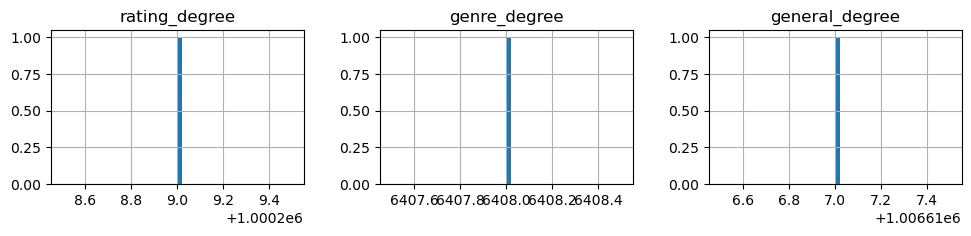

In [6]:
movies_degree = pd.DataFrame()
movies_degree["rating_degree"] = degree_counts("Movie", "RATED", "IN")["degreeCount"]
movies_degree["genre_degree"] = degree_counts("Movie", "IN_GENRE", "OUT")["degreeCount"]
movies_degree["tag_degree"] = degree_counts("Movie", "TAGGED", "IN")["degreeCount"]
movies_degree["general_degree"] = degree_counts("Movie", "", "")["degreeCount"]

movies_degree.hist(bins=50, figsize=(16, 2), layout=(1, 4))
movies_degree.describe().T.round(2)
# TODO: maybe print also box plots

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/graphdatascience/query_runner/neo4j_query_runner.py:224: RuntimeWarning: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: TAGGED)
  warnings.warn(warning)


,count,mean,std,min,25%,50%,75%,max
rating_degree,1.0,1000209.0,NaN,1000209.0,1000209.0,1000209.0,1000209.0,1000209.0
general_degree,1.0,1000209.0,NaN,1000209.0,1000209.0,1000209.0,1000209.0,1000209.0


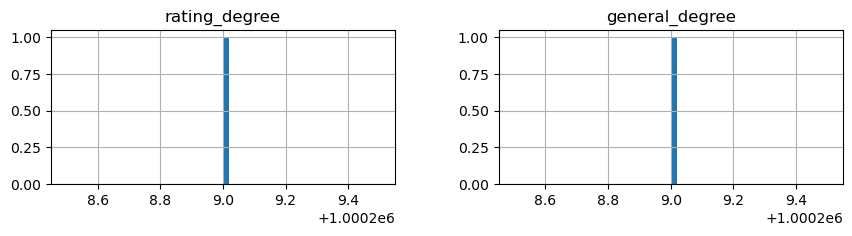

In [7]:
user_degree = pd.DataFrame()
user_degree["rating_degree"] = degree_counts("User", "RATED", "OUT")["degreeCount"]
user_degree["tag_degree"] = degree_counts("User", "TAGGED", "OUT")["degreeCount"]
user_degree["general_degree"] = degree_counts("User", "", "")["degreeCount"]

user_degree.hist(bins=50, figsize=(16, 2), layout=(1, 3))
user_degree.describe().T.round(2)

<Axes: >

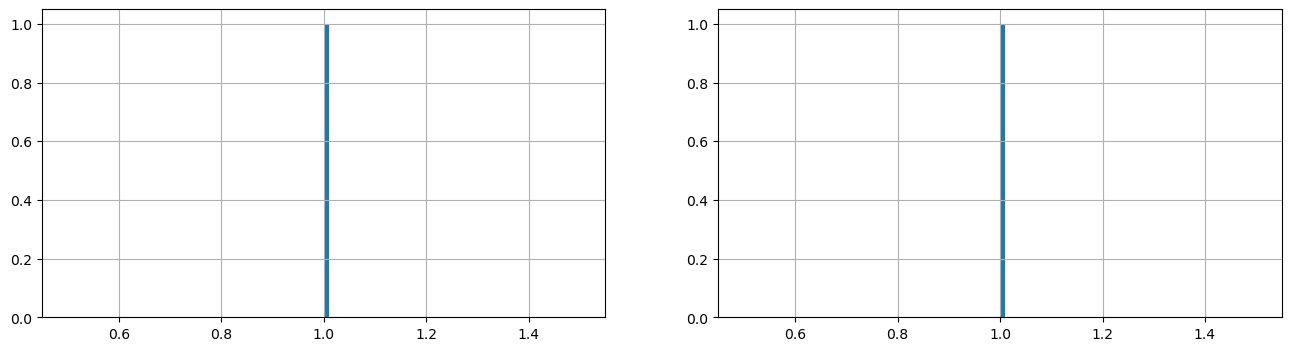

In [8]:
movies_degree_pdf = (
    movies_degree["general_degree"] / movies_degree["general_degree"].sum()
)
user_degree_pdf = user_degree["general_degree"] / user_degree["general_degree"].sum()

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
movies_degree_pdf.hist(bins=100, ax=ax[0])
user_degree_pdf.hist(bins=100, ax=ax[1])

<Axes: xlabel='rating'>

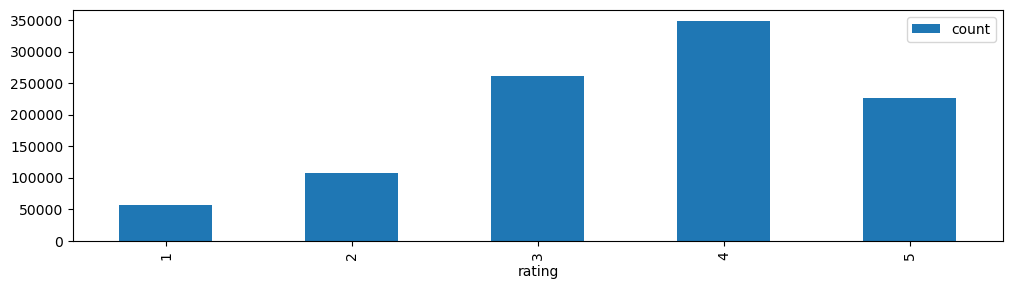

In [9]:
ratings_vote_distribution = gds.run_cypher(
    """
    MATCH (u:User)-[r:RATED]->(m:Movie)
    RETURN r.rating as rating, COUNT(*) as count
    ORDER BY rating;
"""
)
ratings_vote_distribution.plot(kind="bar", x="rating", y="count", figsize=(12, 3))

<Axes: xlabel='genre'>

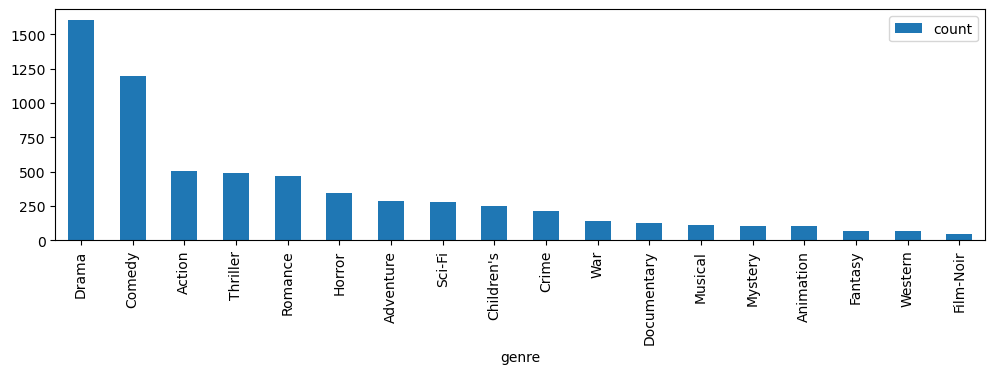

In [10]:
movies_per_genre_distributions = gds.run_cypher(
    """
    MATCH (m:Movie)-[:IN_GENRE]->(g:Genre)
    RETURN g.name as genre, COUNT(m) as count
    ORDER BY count DESC;
"""
)
movies_per_genre_distributions.plot(kind="bar", x="genre", y="count", figsize=(12, 3))

## Centrality analysis

In [19]:
# TODO: implementa gli algoritmi di community e raccomandation system (vedi docs di GDS)